<a href="https://colab.research.google.com/github/nathan-tw/COVID_mining/blob/master/wuhan%20coronavirus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import 套件

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

# 先查看資料格式

In [0]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/03-10-2020.csv'
march10 = pd.read_csv(url)
march10.head()

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude
0,Hubei,Mainland China,2020-03-10T15:13:05,67760,3024,47743,30.9756,112.2707
1,NaN,Italy,2020-03-10T17:53:02,10149,631,724,43.0000,12.0000
2,NaN,Iran (Islamic Republic of),2020-03-10T19:13:20,8042,291,2731,32.0000,53.0000
3,NaN,Republic of Korea,2020-03-10T19:13:20,7513,54,247,36.0000,128.0000
4,NaN,France,2020-03-10T18:53:02,1784,33,12,47.0000,2.0000


# 以3/10為例，畫出散佈圖及熱點圖

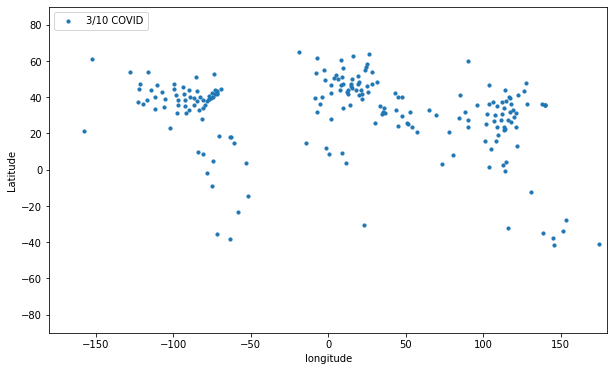

In [0]:
# plot 3/10's COVID infection instances on a earth map
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.scatter(march10.Longitude, march10.Latitude, alpha = 1, s = 10, label = "3/10 COVID")
ax.set_xlim((-180, 180))
ax.set_ylim((-90, 90))

plt.xlabel("longitude")
plt.ylabel("Latitude")
plt.legend(loc='upper left')
plt.show()

In [0]:
import folium
from folium.plugins import HeatMap
mapa = folium.Map(location=(20, 20), zoom_start=1, tiles="Stamen Toner", height="50%", width="50%")
loc_li = list(zip(march10.Latitude, march10.Longitude))
HeatMap(loc_li, radius=15).add_to(mapa) # <-----------------------change radius
mapa

# 為2月以前的資料加上座標，以3/10的座標join

In [0]:
date = datetime.date(2020, 1, 22)
oneDay = datetime.timedelta(days=1)
dueDate = datetime.date(2020, 3, 18)

In [0]:
dailys = []
while date!= dueDate:
  _ = date.strftime('%m-%d-%Y')
  dailys.append(pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{}.csv'.format(_), index_col=[0,1]))
  date+=oneDay

In [0]:
location = dailys[48][['Latitude', 'Longitude']]

In [0]:
allDailyReports = []
for i in range(39):
    allDailyReports.append(dailys[i].join(location, how='inner',lsuffix='_'))

In [0]:
allDailyReports = allDailyReports+dailys[39:]

## 從1/22開始將傳染區域畫出

In [0]:
from folium.plugins import HeatMapWithTime

In [0]:
heatMapList = []
for each in allDailyReports:
  loc = [list(a) for a in zip(each.Latitude, each.Longitude)]
  heatMapList.append(loc)

In [0]:
fmap = folium.Map(location=(20, 20), zoom_start=1, tiles="Stamen Toner", height="50%", width="50%")
fmap.add_child(HeatMapWithTime(heatMapList)) # 顯示連續熱度圖

# 各國確診成長趨勢比較

In [0]:
trend = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

In [0]:
trend.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,14,14,14,19,19,19,19,25,25,25,25,32,32,32,33,33,33,33,33,34,35,35,35,35,35,35,35,35,37,40,40,41,42,42,43,43,43,47,48,50,50,50,53,59,70,75,82,114,147,177,212,272
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,7,7,11,15,20,20,20,22,22,45,25,25,26,26,26,28,28,29,43,59,66,74,84,94,105,122,147,159,170,189,214,228,241,256,274,293,331,360,420,461,502,511,581,639,639,701,773,839,825,878,889,924
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,7,7,10,13,16,18,18,24,28,28,30,33,40,45,47,50,58,67,72,75,77,81,84,84,85,85,89,89,91,93,93,93,102,106,108,110,110,117,130,138,150,150,160,178,178,200,212,226,243,266,313,345
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,4,7,8,8,8,8,8,10,12,12,12,16,16,18,18,18,19,19,22,22,22,22,22,22,22,22,22,22,22,22,23,23,25,29,29,36,50,50,83,93,99,117,129,149,149,197,238,428,566,673,790,900


In [0]:
trend = trend.drop(columns=['Lat', 'Long', 'Province/State'])
aggr_func = {i:'sum' for i in trend.columns[1:]}

In [0]:
trend = trend.groupby(['Country/Region'],as_index=False).agg(aggr_func).sort_values(by=['3/18/20'],ascending=False)
confirmed = trend[trend['3/18/20']!=0].set_index('Country/Region')

In [0]:
top5 = confirmed[:5].T

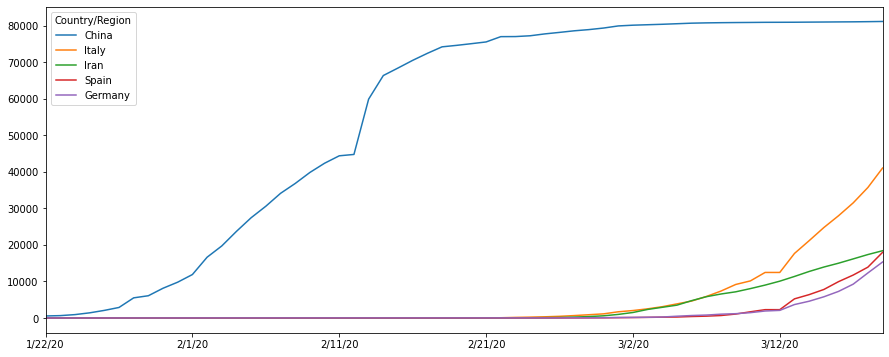

In [0]:
top5.plot(figsize=(15,6))

# 截至目前各國感染比例

In [0]:
p = confirmed[['3/18/20']]/confirmed['3/18/20'].sum()

In [0]:
p.head()

,3/18/20
Country/Region,
China,0.377377
Italy,0.166177
Iran,0.080783
Spain,0.064725
Germany,0.057359


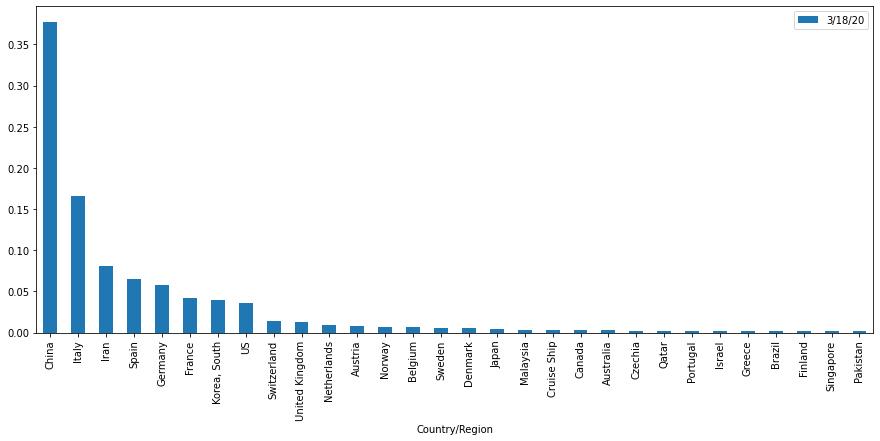

In [0]:
p[:30].plot.bar(figsize=(15,6))

# 各國痊癒率及死亡率

In [0]:
def df_Regular(df, threshold):
    df = df.groupby(['Country/Region'],as_index=False).agg(aggr_func).sort_values(by=['3/18/20'],ascending=False)
    df = df[df['3/18/20']>=threshold].set_index('Country/Region')
    df = df[['3/18/20']]
    return df

In [0]:
rec = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')
death = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')
conf = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

In [0]:
rec = df_Regular(rec, 1)
death = df_Regular(death, 1)
conf = df_Regular(conf, 5)

In [0]:
recoverRate = (rec/conf).sort_values(by='3/18/20', ascending=False)

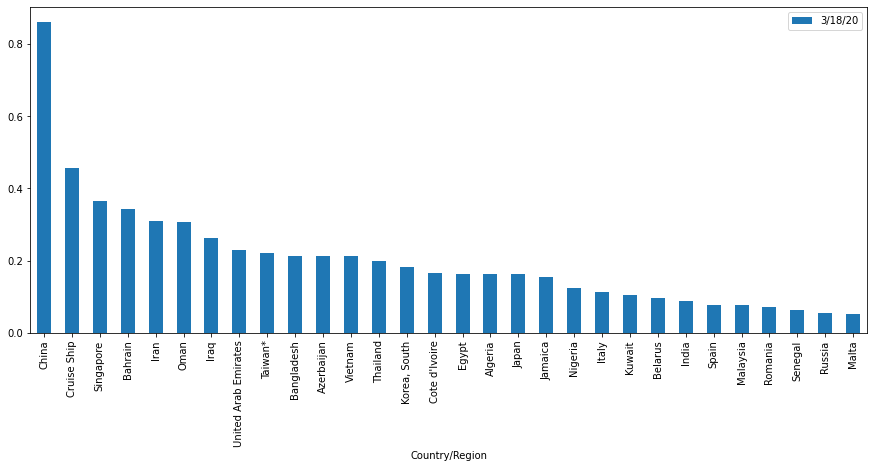

In [0]:
recoverRate[:30].plot.bar(figsize=(15, 6))

In [0]:
deathRate = (death/conf).sort_values(by='3/18/20', ascending=False)

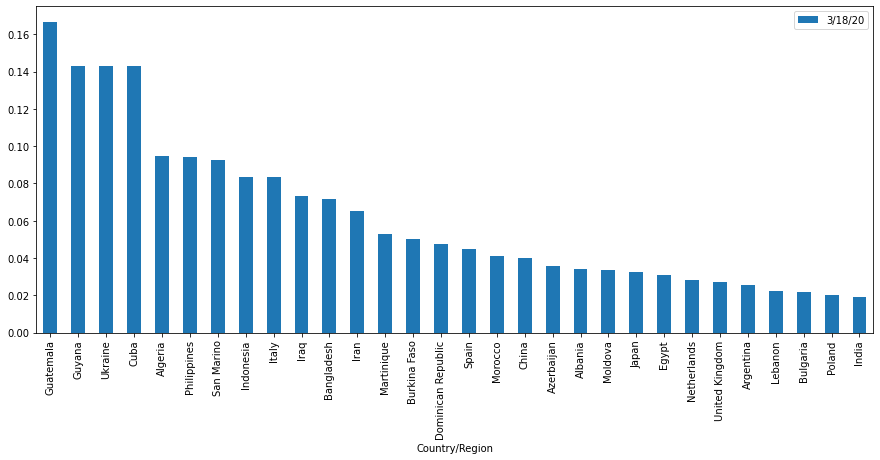

In [0]:
deathRate[:30].plot.bar(figsize=(15, 6))

In [0]:
death_recover = pd.concat([deathRate['3/18/20'].rename('deathRate'), recoverRate['3/18/20'].rename('recoverRate')], axis=1, sort=True).dropna(how='any')

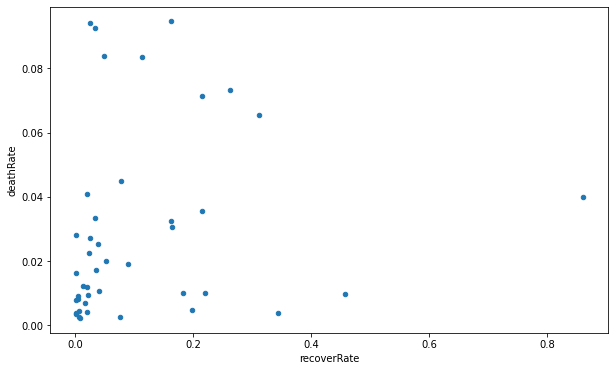

In [0]:
death_recover.plot.scatter(x='recoverRate', y='deathRate', figsize=(10,6))

In [0]:
from sklearn.linear_model import LinearRegression

In [0]:
x = death_recover.recoverRate
y = death_recover.deathRate

In [0]:
regr = LinearRegression()
regr.fit(x, y)

ValueError: ignored

TypeError: ignored

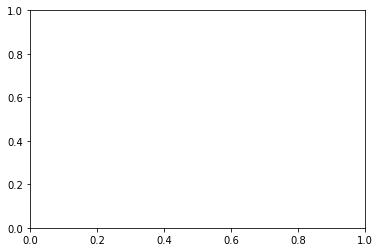

In [0]:
plt.plot(regr)